In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# California


https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-california-census-tracts

In [ ]:
!unzip /content/tl_2021_06_tract.zip

Archive:  /content/tl_2021_06_tract.zip
 extracting: tl_2021_06_tract.cpg    
  inflating: tl_2021_06_tract.dbf    
  inflating: tl_2021_06_tract.prj    
  inflating: tl_2021_06_tract.shp    
  inflating: tl_2021_06_tract.shp.ea.iso.xml  
  inflating: tl_2021_06_tract.shp.iso.xml  
  inflating: tl_2021_06_tract.shx    


<Axes: >

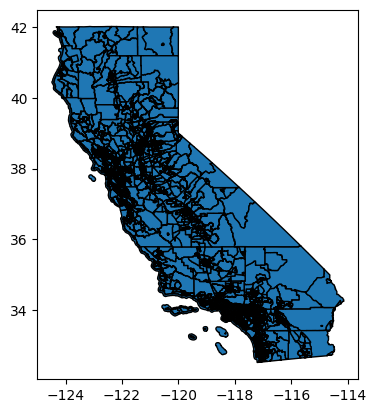

In [ ]:
import geopandas


tl = geopandas.read_file("tl_2021_06_tract.shp").to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,06085504321,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,"POLYGON ((-122.02489 37.21683, -122.02458 37.2..."
3,06085507004,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...
9124,06059001303,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,"POLYGON ((-117.95918 33.9282, -117.95831 33.92..."
9126,06059001401,"POLYGON ((-117.95056 33.94503, -117.95056 33.9..."
9127,06013367200,"POLYGON ((-122.34551 37.96355, -122.3455 37.96..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,06085504321,"POLYGON ((-121.875559 37.39924, -121.875352 37..."
1,06085504410,"POLYGON ((-121.888863 37.407575, -121.885763 3..."
2,06085507003,"POLYGON ((-122.024891 37.216828, -122.024585 3..."
3,06085507004,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,"POLYGON ((-121.931674 37.29803, -121.928011 37..."
...,...,...
9124,06059001303,"POLYGON ((-117.959174 33.92458, -117.958881 33..."
9125,06059001304,"POLYGON ((-117.959178 33.928202, -117.958306 3..."
9126,06059001401,"POLYGON ((-117.950559 33.945034, -117.950555 3..."
9127,06013367200,"POLYGON ((-122.345508 37.963547, -122.3455 37...."


In [ ]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


In [ ]:
!pip install geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -U pip setuptools wheel
!pip install -U pyarrow h3 h3ronpy
!pip install torch-cluster

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 121.2 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.9/542.9 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.6/792.6 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
   ━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 96.3 MB/s  0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
%pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib

%pip install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cpu

%pip install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
Found existing installation: torch_scatter 2.1.2+pt24cpu
Uninstalling torch_scatter-2.1.2+pt24cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt24cpu
Found existing installation: torch_sparse 0.6.18+pt24cpu
Uninstalling torch_sparse-0.6.18+pt24cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt24cpu
Found existing installation: torch_cluster 1.6.3+pt24cpu
Uninstalling torch_cluster-1.6.3+pt24cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt24cpu
Found existing installation: torch_spline_conv 1.2.2+pt24cpu
Uninstalling torch_spline_conv-1.2.2+pt24cpu:
  Successfully uninstalled torch_spline_conv-1.2.2+pt24cpu
Found existing installation: pyg_lib 0.4.0+pt24cpu
Uninstalling pyg_lib-0.4.0+pt24cpu:
  Successfully uninstalled pyg_lib-0.4.0+pt24cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.5 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.9/542.9 kB 579.8 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 152.0 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.6/792.6 kB 804.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch-geometric]


## POI Embedding

In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point

CHECKIN_NAO_CRU = "checkins_California.csv"
CHECKIN_CRU     = "checkins_California_crus.csv"

OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-2041770748.py:66: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:
!pip install --upgrade torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 22.4 MB/s  0:00:17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 18.1 MB/s  0:00:20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 77.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 55.6 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 39.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 68.5 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 54.5 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 70.8 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 68.3 MB/s  0:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 50.1 MB/s  0:00:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 50.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 MB 61.3 MB/s  0:00:0

In [ ]:
!pip install torch-cluster

In [ ]:
from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/libpyg.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cpu.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spli

boroughs cols: ['GEOID', 'geometry']
        GEOID                                           geometry
0  6085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1  6085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2  6085507003  POLYGON ((-122.02489 37.21683, -122.02458 37.2...
3  6085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4  6085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...
           GEOID                                           geometry
0     6085504321  POLYGON ((-121.87556 37.39924, -121.87535 37.3...
1     6085504410  POLYGON ((-121.88886 37.40758, -121.88576 37.4...
2     6085507003  POLYGON ((-122.02489 37.21683, -122.02458 37.2...
3     6085507004  POLYGON ((-121.99304 37.22562, -121.99249 37.2...
4     6085502204  POLYGON ((-121.93167 37.29803, -121.92801 37.3...
...          ...                                                ...
9124  6059001303  POLYGON ((-117.95917 33.92458, -117.95888 33.9...
9125  6059001304  POLYGON ((-

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


        source  target    weight
0            0    5307  0.626057
1            0     164  0.651860
2            0    3344  0.585451
3            0  138918  0.612438
4            0  129987  0.620526
...        ...     ...       ...
444913  148253  148255  0.653744
444914  148308  148310  0.654397
444915  148308  148309  0.630476
444916  148309  148310  0.655578
444917  148311  148312  0.750888

[444918 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


        source  target    weight
0            0    5307  0.626057
1            0     164  0.651860
2            0    3344  0.585451
3            0  138918  0.612438
4            0  129987  0.620526
...        ...     ...       ...
444913  148253  148255  0.653744
444914  148308  148310  0.654397
444915  148308  148309  0.630476
444916  148309  148310  0.655578
444917  148311  148312  0.750888

[444918 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 1115, 3586, 3655.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
        feature_id  category  fclass                     geometry  \
0             8947         0       0  POINT (-122.02963 37.33188)   
1             9060         1       1  POINT (-122.40583 37.80236)   
2             9062         0       0  POINT (-122.44951 37.79847)   
3             9063         0       0  POINT (-122.39825 37.79803)   
4             9064         1       2  POINT (-122.40316 37.79536)   
...            ...       ...     ...                          ...   
148308     7605320         3     213  POINT (-122.50092 37.73343)   
148309     7605336         3     213  POINT (-122.50024 37.73386)   
148310     7605363         3     213  POINT (-122.50089 37.73395)   
148311     7605423         1      22  POINT (-122.50445 37.73387)   
148312     7605448         3     213    POINT (-122.50459 37.734)   

        index_right       GEOID  row_idx  
0              6869  6085508101        0  
1              3234  6075010402        1  
2    

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

creating region similarity by cosine similarity of embeddings
finishing preprocessing


In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 8366
R area    : 8366
R adj     : 8366
R sim     : 8366


## Treino

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.8.0+cu126
True


In [ ]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device cuda --save_name gowalla_h3


Streaming output truncated to the last 5000 lines.
        [-0.0435, -0.0412,  0.0737,  ..., -0.1084,  0.1033,  0.0394]],
       device='cuda:0', requires_grad=True) Parameter containing:
tensor([[ 0.0660,  0.0983,  0.0740,  ...,  0.0925, -0.0150, -0.0614],
        [-0.0973,  0.0600,  0.0889,  ..., -0.1110,  0.0950, -0.0291],
        [-0.0615, -0.0759, -0.0520,  ..., -0.0478,  0.0460,  0.0746],
        ...,
        [ 0.0035, -0.0428,  0.0359,  ...,  0.0339,  0.0310,  0.0254],
        [-0.0693, -0.1289,  0.0622,  ...,  0.1228, -0.0268, -0.1184],
        [ 0.0251, -0.0048, -0.0106,  ...,  0.1177,  0.1313,  0.0361]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0119,  0.0029, -0.1066,  ..., -0.0530, -0.2042,  0.1115],
        [-0.0286,  0.1018,  0.0674,  ...,  0.0842,  0.0144,  0.0048],
        [ 0.1221, -0.0483, -0.0690,  ..., -0.0583,  0.0458,  0.0901],
        ...,
        [-0.0764,  0.1327, -0.0510,  ..., -0.0014, -0.0866, -0.0066],
        [-0.0245,  

# Montana

Census:https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-montana-census-tracts

In [ ]:
!unzip /content/tl_2021_30_tract.zip

Archive:  /content/tl_2021_30_tract.zip
 extracting: tl_2021_30_tract.cpg    
  inflating: tl_2021_30_tract.dbf    
  inflating: tl_2021_30_tract.prj    
  inflating: tl_2021_30_tract.shp    
  inflating: tl_2021_30_tract.shp.ea.iso.xml  
  inflating: tl_2021_30_tract.shp.iso.xml  
  inflating: tl_2021_30_tract.shx    


<Axes: >

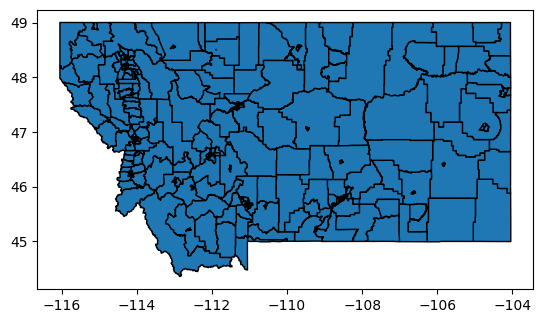

In [ ]:
import geopandas


tl = geopandas.read_file("tl_2021_30_tract.shp").to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,30111001300,"POLYGON ((-108.60195 45.80163, -108.60192 45.8..."
1,30111001702,"POLYGON ((-108.57625 45.77692, -108.57613 45.7..."
2,30111000704,"POLYGON ((-108.5707 45.82331, -108.57063 45.82..."
3,30111000902,"POLYGON ((-108.52542 45.76976, -108.5245 45.76..."
4,30111000200,"POLYGON ((-108.53398 45.80169, -108.53199 45.8..."
...,...,...
314,30087940400,"POLYGON ((-106.72961 45.40753, -106.72961 45.4..."
315,30087000300,"POLYGON ((-106.69316 45.87987, -106.69258 45.8..."
316,30087000200,"POLYGON ((-107.00756 46.30764, -107.00563 46.3..."
317,30087000100,"POLYGON ((-107.89762 46.8486, -107.89743 46.84..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,30111001300,"POLYGON ((-108.601947 45.801632, -108.601919 4..."
1,30111001702,"POLYGON ((-108.576247 45.776925, -108.576126 4..."
2,30111000704,"POLYGON ((-108.570705 45.823311, -108.570632 4..."
3,30111000902,"POLYGON ((-108.525422 45.769761, -108.524497 4..."
4,30111000200,"POLYGON ((-108.53398 45.801689, -108.531994 45..."
...,...,...
314,30087940400,"POLYGON ((-106.729614 45.407528, -106.729612 4..."
315,30087000300,"POLYGON ((-106.693155 45.879866, -106.692576 4..."
316,30087000200,"POLYGON ((-107.007558 46.307645, -107.005634 4..."
317,30087000100,"POLYGON ((-107.897619 46.848602, -107.897429 4..."




```
# Isto está formatado como código
```



In [ ]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


In [ ]:
!pip install geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -U pip setuptools wheel
!pip install -U pyarrow h3 h3ronpy
!pip install torch-cluster

Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 MB 72.5 MB/s  0:00:02
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cpu
    Uninstalling torch-2.4.0+cpu:
      Successfully uninstalled torch-2.4.0+cpu


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/pyg_lib-0.4.0%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (1.3 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_scatter-2.1.2%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (542 kB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_sparse-0.6.18%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (1.2 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_cluster-1.6.3%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (792 kB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_spline_conv-1.2.2%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (237 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch-geometric]
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html


In [ ]:
%pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib

%pip install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cpu

%pip install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Found existing installation: torch_scatter 2.1.2+pt24cpu
Uninstalling torch_scatter-2.1.2+pt24cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt24cpu
Found existing installation: torch_sparse 0.6.18+pt24cpu
Uninstalling torch_sparse-0.6.18+pt24cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt24cpu
Found existing installation: torch_cluster 1.6.3+pt24cpu
Uninstalling torch_cluster-1.6.3+pt24cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt24cpu
Found existing installation: torch_spline_conv 1.2.2+pt24cpu
Uninstalling torch_spline_conv-1.2.2+pt24cpu:
  Successfully uninstalled torch_spline_conv-1.2.2+pt24cpu
Found existing installation: pyg_lib 0.4.0+pt24cpu
Uninstalling pyg_lib-0.4.0+pt24cpu:
  Successfully uninstalled pyg_lib-0.4.0+pt24cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## POI Embedding

In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point

CHECKIN_NAO_CRU = "checkins_Montana.csv"
CHECKIN_CRU     = "checkins_Montana_crus.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-3082839696.py:66: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:


from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1  30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2  30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3  30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4  30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
           GEOID                                           geometry
0    30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1    30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2    30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3    30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4    30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
..           ...                                                ...
314  30087940400  POLYGON ((-106.72961 45.40753, -106.72961 45.4...
315  30087000300  POLYG

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 6 islands with ids: 31, 86, 109, 142, 178, 180.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
      feature_id  category  fclass                     geometry  index_right  \
0           9413         0       0  POINT (-114.08428 46.91893)          159   
1          57226         0       0  POINT (-114.25269 48.30766)          229   
2          57244         1       1  POINT (-114.33695 48.41222)           35   
3          57269         0       2  POINT (-114.33162 48.40026)          147   
4          57456         1       3   POINT (-114.33622 48.4097)           35   
...          ...       ...     ...                          ...          ...   
1219     7555386         6     146  POINT (-111.27907 47.51297)          105   
1220     7562685         2      14  POINT (-111.09938 44.66297)           37   
1221     7562747         1      15  POINT (-111.09994 44.66112)           37   
1222     7563383         3      33  POINT (-112.50579 45.98295)           86   
1223     7565831         6     146  POINT (-108.56642 45.75476)          123   

  

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 208
R area    : 208
R adj     : 208
R sim     : 208


In [ ]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device gpu --save_name gowalla_h3


Traceback (most recent call last):
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 42, in <module>
    data = hgi_graph(args.city).to(args.device)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 362, in to
    return self.apply(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 342, in apply
    store.apply(func, *args)
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/storage.py", line 201, in apply
    self[key] = recursive_apply(value, func)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/storage.py", line 897, in recursive_apply
    return func(data)
           ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 363, in <lamb

# Alabama


Census: https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-alabama-census-tracts

In [ ]:
!unzip /content/tl_2021_30_tract.zip

Archive:  /content/tl_2021_30_tract.zip
 extracting: tl_2021_30_tract.cpg    
  inflating: tl_2021_30_tract.dbf    
  inflating: tl_2021_30_tract.prj    
  inflating: tl_2021_30_tract.shp    
  inflating: tl_2021_30_tract.shp.ea.iso.xml  
  inflating: tl_2021_30_tract.shp.iso.xml  
  inflating: tl_2021_30_tract.shx    


<Axes: >

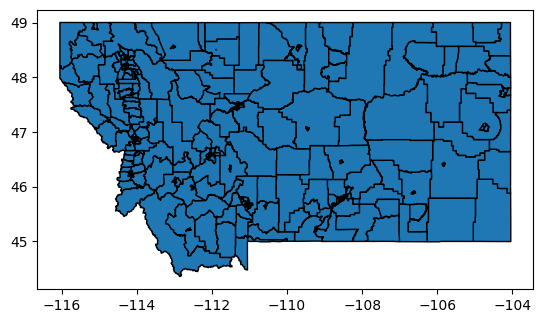

In [ ]:
import geopandas


tl = geopandas.read_file("tl_2021_30_tract.shp").to_crs("EPSG:4326")
tl.plot(edgecolor="black")


In [ ]:
tl[["GEOID","geometry"]] ##TODO: Passar arquivo para HGI (CSV)

## BORO -> GEOID

,GEOID,geometry
0,30111001300,"POLYGON ((-108.60195 45.80163, -108.60192 45.8..."
1,30111001702,"POLYGON ((-108.57625 45.77692, -108.57613 45.7..."
2,30111000704,"POLYGON ((-108.5707 45.82331, -108.57063 45.82..."
3,30111000902,"POLYGON ((-108.52542 45.76976, -108.5245 45.76..."
4,30111000200,"POLYGON ((-108.53398 45.80169, -108.53199 45.8..."
...,...,...
314,30087940400,"POLYGON ((-106.72961 45.40753, -106.72961 45.4..."
315,30087000300,"POLYGON ((-106.69316 45.87987, -106.69258 45.8..."
316,30087000200,"POLYGON ((-107.00756 46.30764, -107.00563 46.3..."
317,30087000100,"POLYGON ((-107.89762 46.8486, -107.89743 46.84..."


In [ ]:
import geopandas as gpd
from shapely import wkt

boroughs = tl[["GEOID", "geometry"]].copy()
boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)

boroughs.to_csv("/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/boroughs_area.csv", index=False)


/tmp/ipython-input-3210474560.py:5: UserWarning: Geometry column does not contain geometry.
  boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)


In [ ]:
boroughs

,GEOID,geometry
0,30111001300,"POLYGON ((-108.601947 45.801632, -108.601919 4..."
1,30111001702,"POLYGON ((-108.576247 45.776925, -108.576126 4..."
2,30111000704,"POLYGON ((-108.570705 45.823311, -108.570632 4..."
3,30111000902,"POLYGON ((-108.525422 45.769761, -108.524497 4..."
4,30111000200,"POLYGON ((-108.53398 45.801689, -108.531994 45..."
...,...,...
314,30087940400,"POLYGON ((-106.729614 45.407528, -106.729612 4..."
315,30087000300,"POLYGON ((-106.693155 45.879866, -106.692576 4..."
316,30087000200,"POLYGON ((-107.007558 46.307645, -107.005634 4..."
317,30087000100,"POLYGON ((-107.897619 46.848602, -107.897429 4..."




```
# Isto está formatado como código
```



In [ ]:
%cd drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main


In [ ]:
!pip install geopandas shapely libpysal h3 h3ronpy pyarrow scipy scikit-learn
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -U pip setuptools wheel
!pip install -U pyarrow h3 h3ronpy
!pip install torch-cluster

Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 MB 72.5 MB/s  0:00:02
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cpu
    Uninstalling torch-2.4.0+cpu:
      Successfully uninstalled torch-2.4.0+cpu


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/pyg_lib-0.4.0%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (1.3 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_scatter-2.1.2%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (542 kB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_sparse-0.6.18%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (1.2 MB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_cluster-1.6.3%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (792 kB)
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_spline_conv-1.2.2%2Bpt24cpu-cp312-cp312-linux_x86_64.whl (237 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch-geometric]
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html


In [ ]:
%pip uninstall -y torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib

%pip install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 \
  --index-url https://download.pytorch.org/whl/cpu

%pip install --no-cache-dir pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cpu.html


Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Found existing installation: torch_scatter 2.1.2+pt24cpu
Uninstalling torch_scatter-2.1.2+pt24cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt24cpu
Found existing installation: torch_sparse 0.6.18+pt24cpu
Uninstalling torch_sparse-0.6.18+pt24cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt24cpu
Found existing installation: torch_cluster 1.6.3+pt24cpu
Uninstalling torch_cluster-1.6.3+pt24cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt24cpu
Found existing installation: torch_spline_conv 1.2.2+pt24cpu
Uninstalling torch_spline_conv-1.2.2+pt24cpu:
  Successfully uninstalled torch_spline_conv-1.2.2+pt24cpu
Found existing installation: pyg_lib 0.4.0+pt24cpu
Uninstalling pyg_lib-0.4.0+pt24cpu:
  Successfully uninstalled pyg_lib-0.4.0+pt24cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## POI Embedding

In [ ]:
import pandas as pd, numpy as np, ast
import geopandas as gpd
from shapely.geometry import Point

CHECKIN_NAO_CRU = "checkins_Montana.csv"
CHECKIN_CRU     = "checkins_Montana_crus.csv"
OUT_POIS        = "pois_gowalla.csv"

df_labeled = pd.read_csv(CHECKIN_NAO_CRU)
df_raw     = pd.read_csv(CHECKIN_CRU)

lon_col_raw = "lng" if "lng" in df_raw.columns else "longitude"
lat_col_raw = "lat" if "lat" in df_raw.columns else "latitude"
lon_col_lab = "lng" if "lng" in df_labeled.columns else ("longitude" if "longitude" in df_labeled.columns else None)
lat_col_lab = "lat" if "lat" in df_labeled.columns else ("latitude" if "latitude" in df_labeled.columns else None)

def parse_names(cell):
    try:
        lst = ast.literal_eval(cell)
        if isinstance(lst, list):
            return [d.get("name") for d in lst if isinstance(d, dict) and "name" in d]
    except Exception:
        pass
    return []

df_raw["__cat_names"] = df_raw["spot_categories"].fillna("[]").apply(parse_names)

def first_or_none(lst):
    return lst[0] if (isinstance(lst, list) and len(lst) > 0) else None

df_raw["__fclass_name"] = df_raw["__cat_names"].apply(first_or_none)

fclass_by_place = (df_raw.dropna(subset=["__fclass_name"])
                          .groupby("placeid")["__fclass_name"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

cat_by_place = (df_labeled.dropna(subset=["category"])
                          .groupby("placeid")["category"]
                          .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))

coords_raw = (df_raw.groupby("placeid")[[lat_col_raw, lon_col_raw]]
                    .mean()
                    .rename(columns={lat_col_raw: "latitude", lon_col_raw: "longitude"}))

if coords_raw.empty and lon_col_lab and lat_col_lab and (lon_col_lab in df_labeled.columns) and (lat_col_lab in df_labeled.columns):
    coords_raw = (df_labeled.groupby("placeid")[[lat_col_lab, lon_col_lab]]
                           .mean()
                           .rename(columns={lat_col_lab: "latitude", lon_col_lab: "longitude"}))

coords_raw = coords_raw.dropna()

pois = pd.DataFrame({"feature_id": coords_raw.index})
pois["feature_id"] = pois["feature_id"].astype(int)

pois["fclass_name"]   = fclass_by_place.reindex(pois["feature_id"]).values
pois["category_name"] = cat_by_place.reindex(pois["feature_id"]).values

pois = pois.dropna(subset=["fclass_name", "category_name"]).reset_index(drop=True)

gdf = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(coords_raw.loc[pois["feature_id"], "longitude"].values,
                                coords_raw.loc[pois["feature_id"], "latitude"].values),
    crs="EPSG:4326"
)
gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)

fclass_vocab = {n:i for i,n in enumerate(pd.Series(gdf["fclass_name"]).dropna().unique())}
cat_vocab    = {n:i for i,n in enumerate(pd.Series(gdf["category_name"]).dropna().unique())}

gdf["fclass"]   = gdf["fclass_name"].map(lambda n: fclass_vocab.get(n, -1)).astype(int)
gdf["category"] = gdf["category_name"].map(lambda n: cat_vocab.get(n, -1)).astype(int)

gdf = gdf[(gdf["fclass"]>=0) & (gdf["category"]>=0)].reset_index(drop=True)

pois_out = gdf[["feature_id", "category", "fclass", "geometry"]].copy()
pois_out.to_csv(OUT_POIS, index=False)



/tmp/ipython-input-3082839696.py:66: UserWarning: Geometry column does not contain geometry.
  gdf["geometry"] = gdf.geometry.apply(lambda p: p.wkt)


In [ ]:
# @title
import geopandas as gpd
from shapely.geometry import box

lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
lon_min, lon_max = df["longitude"].min(), df["longitude"].max()
area = box(lon_min, lat_min, lon_max, lat_max).buffer(0.01)

boroughs = gpd.GeoDataFrame(geometry=[area], crs="EPSG:4326")

boroughs["geometry"] = boroughs["geometry"].apply(lambda g: g.wkt)
boroughs.to_csv("boroughs_area.csv", index=False)


In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/poi-encoder'

sys.path.insert(0, module_dir)

In [ ]:


from POIEmbedding import PreProcess

PreProcess("pois_gowalla.csv", "boroughs_area.csv", h3=False).run() ##TODO H3 FALSO


boroughs cols: ['GEOID', 'geometry']
         GEOID                                           geometry
0  30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1  30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2  30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3  30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4  30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
           GEOID                                           geometry
0    30111001300  POLYGON ((-108.60195 45.80163, -108.60192 45.8...
1    30111001702  POLYGON ((-108.57625 45.77692, -108.57613 45.7...
2    30111000704  POLYGON ((-108.5707 45.82331, -108.57063 45.82...
3    30111000902  POLYGON ((-108.52542 45.76976, -108.5245 45.76...
4    30111000200  POLYGON ((-108.53398 45.80169, -108.53199 45.8...
..           ...                                                ...
314  30087940400  POLYGON ((-106.72961 45.40753, -106.72961 45.4...
315  30087000300  POLYG

In [ ]:
from POIEmbedding import POI2Vec
p = POI2Vec()
p.train()
p.save_walks()


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from POIEmbedding import POI2Vec
from model import POISet, EmbeddingModel
import torch, torch.utils.data as tud

poi2vec = POI2Vec()
poi2vec.read_walks()
poi2vec.get_global_second_class_walks()

second_class_hierarchy_pairs = list(set([tuple(x) for x in poi2vec.pois[["category","fclass"]].to_numpy()]))
dataset = POISet(
    poi2vec.second_class_number,
    poi2vec.second_class_walks,
    poi2vec.global_second_class_walks,
    k=5
)
model = EmbeddingModel(
    vocab_size=poi2vec.second_class_number,
    embed_size=64,
    second_class_hierarchy_pairs=second_class_hierarchy_pairs,
    le_lambda=1e-8
)

loader = tud.DataLoader(dataset, batch_size=2048, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-2)
for e in range(5):
    for i,(inp,pos,neg) in enumerate(loader):
        opt.zero_grad()
        loss,_ = model(inp.long(), pos.long(), neg.long())
        loss.backward()
        opt.step()

torch.save({"in_embed.weight": model.clone_input_embedding()}, "poi-encoder-gowalla-h3.tensor")


      source  target    weight
0          0    1149  0.448649
1          0      96  0.487299
2          0     804  0.491369
3          0     814  0.505366
4          0     906  0.486308
...      ...     ...       ...
3648    1211    1216  0.371429
3649    1211    1212  0.498321
3650    1212    1213  0.779403
3651    1212    1214  0.515824
3652    1213    1214  0.516458

[3653 rows x 3 columns]


## HGI

In [ ]:
import sys
module_dir = '/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess'

sys.path.insert(0, module_dir)

In [ ]:
POIS = "pois_gowalla.csv"
REGS = "boroughs_area.csv"
EMB  = "poi-encoder-gowalla-h3.tensor"

from main import Preprocess
data_dict = Preprocess(POIS, REGS, EMB, h3=False).get_data_torch()

import torch, pickle
from torch_geometric.data import Data

g = Data(
    x=torch.tensor(data_dict['node_features'], dtype=torch.float32),
    edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
    edge_weight=torch.tensor(data_dict['edge_weight'], dtype=torch.float32),
)
g.region_id  = torch.tensor(data_dict['region_id'], dtype=torch.long)
g.region_area = torch.tensor(data_dict['region_area'], dtype=torch.float32)
g.coarse_region_similarity = torch.tensor(data_dict['coarse_region_similarity'], dtype=torch.float32)
g.region_adjacency = torch.tensor(data_dict['region_adjacency'], dtype=torch.long)

torch.save(g, "gowalla.pt")


reading poi data
reading boroughs data


/usr/local/lib/python3.12/dist-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 6 islands with ids: 31, 86, 109, 142, 178, 180.
  return W(neighbors, **kwargs)


reading boroughs data
creating graph
      feature_id  category  fclass                     geometry  index_right  \
0           9413         0       0  POINT (-114.08428 46.91893)          159   
1          57226         0       0  POINT (-114.25269 48.30766)          229   
2          57244         1       1  POINT (-114.33695 48.41222)           35   
3          57269         0       2  POINT (-114.33162 48.40026)          147   
4          57456         1       3   POINT (-114.33622 48.4097)           35   
...          ...       ...     ...                          ...          ...   
1219     7555386         6     146  POINT (-111.27907 47.51297)          105   
1220     7562685         2      14  POINT (-111.09938 44.66297)           37   
1221     7562747         1      15  POINT (-111.09994 44.66112)           37   
1222     7563383         3      33  POINT (-112.50579 45.98295)           86   
1223     7565831         6     146  POINT (-108.56642 45.75476)          123   

  

/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/preprocess/main.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

In [ ]:
import os, pickle as pkl, torch
from torch_geometric.data import Data

os.makedirs("./data", exist_ok=True)

g = torch.load("./gowalla.pt", map_location="cpu")

data_dict = {
    "node_features": g.x.detach().cpu().numpy(),
    "edge_index": g.edge_index.detach().cpu().numpy(),
    "edge_weight": g.edge_weight.detach().cpu().numpy(),
    "region_id": g.region_id.detach().cpu().numpy(),
    "region_area": g.region_area.detach().cpu().numpy(),
    "coarse_region_similarity": g.coarse_region_similarity.detach().cpu().numpy(),
    "region_adjacency": g.region_adjacency.detach().cpu().numpy(),
}

with open("./data/gowalla_hgi_data.pkl", "wb") as f:
    pkl.dump(data_dict, f)



/tmp/ipython-input-1595378934.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load("./gowalla.pt", map_location="cpu")


In [ ]:
import numpy as np

R_from_id = int(np.max(data_dict["region_id"])) + 1
R_area    = len(data_dict["region_area"])
R_adj     = int(data_dict["region_adjacency"].max()) + 1
R_sim     = data_dict["coarse_region_similarity"].shape[0]

print("R from id :", R_from_id)
print("R area    :", R_area)
print("R adj     :", R_adj)
print("R sim     :", R_sim)

assert R_from_id == R_area == R_adj == R_sim, "Desalinhad"


R from id : 208
R area    : 208
R adj     : 208
R sim     : 208


In [ ]:
!python /content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py --city gowalla --dim 64 --alpha 0.5 --attention_head 4 --epoch 300 --device gpu --save_name gowalla_h3


Traceback (most recent call last):
  File "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/region-embedding/baselines/HGI/train.py", line 42, in <module>
    data = hgi_graph(args.city).to(args.device)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 362, in to
    return self.apply(
           ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 342, in apply
    store.apply(func, *args)
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/storage.py", line 201, in apply
    self[key] = recursive_apply(value, func)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/storage.py", line 897, in recursive_apply
    return func(data)
           ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch_geometric/data/data.py", line 363, in <lamb